# Lesson 6: sMRI Quantification / Statistical Analysis

## Objectives
- Understand the main metrics characterizing the brain morphology
- Extract and rely on a set of metrics to assess the effect of age on multiple cortical regions
- Understand and implement voxel based morphometry to investigate the effect of age without predefined regions

## Python Requirements
- numpy
- pandas
- [matplotlib](https://matplotlib.org/)
- seaborn
- [nibabel](https://nipy.org/nibabel/)
- pybids
- [nilearn](https://nilearn.github.io/index.html)
- statsmodels

## Useful resources:
- FreeSurfer output [description](https://surfer.nmr.mgh.harvard.edu/fswiki/ReconAllTableStableV5.3)

## Dataset used:
- [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI [Collection](https://openneuro.org/datasets/ds002790/versions/2.0.0)

In [441]:
import os
import glob
import numpy as np
import pandas as pd
import nilearn
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

In [442]:
%matplotlib inline

## Quantifying tissue properties

### Get data

In [443]:
from bids import BIDSLayout

In [444]:
data_dir = '../local_data/AOMIC'
fmriprep_dir = '../local_data/AOMIC/derivatives/fmriprep'
fsstats_dir = '../local_data/AOMIC/derivatives/fs_stats'
vbm_dir = '../local_data/AOMIC/derivatives/vbm'

In [445]:
bids_layout = BIDSLayout(data_dir, derivatives=True)
bids_layout

/opt/conda/shared/envs/ni38/lib/python3.8/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


BIDS Layout: ...SDC-BIDS-sMRI/local_data/AOMIC | Subjects: 2 | Sessions: 0 | Runs: 0

### Metric from volumetric data: region volumes

In [446]:
t1_file = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', desc='preproc',
                          extension='nii.gz', return_type='filename')[0]
t1 = nib.load(t1_file)

Let's measure the volume of the right caudate region of our subject, from the subcortical segmentation obtained from Freesurfer.

In [447]:
t1_aseg_file = bids_layout.get(subject="0001", scope="derivatives", 
                               datatype='anat', suffix='dseg',
                               desc="aseg", extension='nii.gz', return_type='filename')[0]

In [452]:
t1_aseg = nib.load(t1_aseg_file)

According to the [Freesurfer look-up table](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT), the ROI of interest has intensity 50.

In [449]:
roi_ix = 50
roi_mask_arr_bool = (t1_aseg.get_fdata() == roi_ix)
roi_mask_arr = roi_mask_arr_bool.astype(int)
roi_mask = nib.Nifti1Image(roi_mask_arr, affine=t1_aseg.affine)

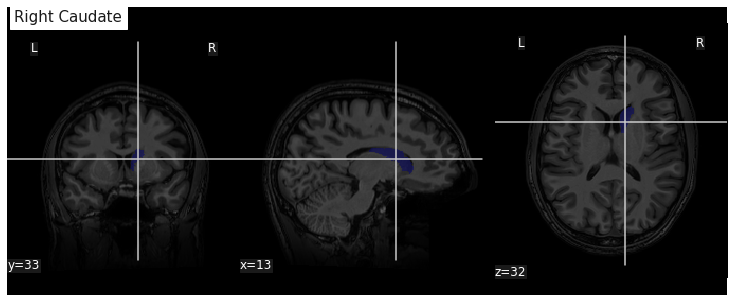

In [450]:
fig = plt.figure(figsize=(10, 4))
plotting.plot_roi(roi_img=roi_mask, bg_img=t1, alpha=0.4, title='Right Caudate', figure=fig);

We can get the number of voxels by counting them in the mask:

In [34]:
caudate_R_n_vox = roi_mask_arr.sum()
caudate_R_n_vox

3854

However we have to take into account voxel sizes in standard unit:

In [453]:
voxel_dimensions = t1.header.get_zooms()
voxel_dimensions

(1.0, 1.0, 1.0)

In [454]:
vox_size = np.array(voxel_dimensions).prod()
vox_size

1.0

The volume of interest in mm3 is then:

In [44]:
caudate_R_vol_mm3 = caudate_R_n_vox * vox_size
caudate_R_vol_mm3

3854.0

Or, since there is always a python module for everything:

In [45]:
import nibabel.imagestats as imagestats
# Volume of the Left hippocampus
imagestats.mask_volume(roi_mask_int)

3854.0

Volume metrics are available for a collection of ROIs in the `aseg.stats` file of the Freesurfer `stats` output directory.

In [458]:
fs_rawstats_dir = "../local_data/AOMIC/derivatives/freesurfer/sub-0001/stats"

In [459]:
from itertools import islice

In [465]:
n_lines = 110
with open(os.path.join(fs_rawstats_dir, "aseg.stats")) as fs_stats_file:
    first_n_lines = list(islice(fs_stats_file, n_lines))

In [466]:
first_n_lines

['# Title Segmentation Statistics \n',
 '# \n',
 '# generating_program mri_segstats\n',
 '# cvs_version $Id: mri_segstats.c,v 1.121 2016/05/31 17:27:11 greve Exp $\n',
 '# cmdline mri_segstats --seg mri/aseg.mgz --sum stats/aseg.stats --pv mri/norm.mgz --empty --brainmask mri/brainmask.mgz --brain-vol-from-seg --excludeid 0 --excl-ctxgmwm --supratent --subcortgray --in mri/norm.mgz --in-intensity-name norm --in-intensity-units MR --etiv --surf-wm-vol --surf-ctx-vol --totalgray --euler --ctab /opt/freesurfer/ASegStatsLUT.txt --subject sub-0001 \n',
 '# sysname  Linux\n',
 '# hostname d8c6a608d514\n',
 '# machine  x86_64\n',
 '# user     root\n',
 '# anatomy_type volume\n',
 '# \n',
 '# SUBJECTS_DIR /out/freesurfer\n',
 '# subjectname sub-0001\n',
 '# Measure BrainSeg, BrainSegVol, Brain Segmentation Volume, 1248820.000000, mm^3\n',
 '# Measure BrainSegNotVent, BrainSegVolNotVent, Brain Segmentation Volume Without Ventricles, 1235952.000000, mm^3\n',
 '# Measure BrainSegNotVentSurf, Brai

The difference in volume is probably from the fact that Freesurfer takes into account the proportion of GM in each voxel. This can be done "geometrically" by looking at the fraction of the voxel inside the GM surface, or by interpreting the probability of GM presence as the GM partial volume. Let's check what we get with the latter.

In [476]:
# Identify the right file with pybids
GM_probmap_file = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', 
                                  label="GM", suffix="probseg", 
                                  extension='nii.gz', return_type='filename')[0]
# Load it with nibabel
GM_probmap = nib.load(GM_probmap_file)

In [478]:
GM_roi_data = np.where(roi_mask_arr_bool, GM_probmap.get_fdata(), 0)
GM_roi_data.sum() * vox_size

3354.5343634674136

### Metric from surface data with Freesurfer: cortical thickness

Freesurfer output by default several files to quantify both volume and surface data of each subject. After processing with smriprep/fmriprep, these files can be found in `derivatives/freesurfer/stats`.

In [79]:
os.listdir(fs_rawstats_dir)

['lh.BA_exvivo.thresh.stats',
 'rh.aparc.a2009s.stats',
 'rh.aparc.pial.stats',
 'rh.aparc.DKTatlas.stats',
 'lh.curv.stats',
 'lh.w-g.pct.stats',
 'wmparc.stats',
 'lh.aparc.stats',
 'rh.BA_exvivo.thresh.stats',
 'rh.BA_exvivo.stats',
 'rh.w-g.pct.stats',
 'lh.aparc.pial.stats',
 'lh.BA_exvivo.stats',
 'rh.curv.stats',
 'aseg.stats',
 'lh.aparc.DKTatlas.stats',
 'lh.aparc.a2009s.stats',
 'rh.aparc.stats']

`aseg` is for subcortical volumetric regions ("segmentation" in Freesurfer-speak) and `aparc` for cortical surface regions ("parcellation" in Freesurfer-speak). `aparc.stats` is for the Desikan-Killiany atlas while `aparc.a2009s.stats` is for the Destrieux atlas (more regions). 

#### Extracting cortical thickness information

Let's take a peek at the data output by Freesurfer before jumping to the clean group aggregated data 

In [63]:
n_lines = 75
with open(os.path.join(fs_rawstats_dir, "lh.aparc.a2009s.stats")) as fs_stats_file:
    first_n_lines = list(islice(fs_stats_file, n_lines))

In [64]:
first_n_lines

['# Table of FreeSurfer cortical parcellation anatomical statistics \n',
 '# \n',
 '# CreationTime 2019/03/02-22:05:09-GMT\n',
 '# generating_program mris_anatomical_stats\n',
 '# cvs_version $Id: mris_anatomical_stats.c,v 1.79 2016/03/14 15:15:34 greve Exp $\n',
 '# mrisurf.c-cvs_version $Id: mrisurf.c,v 1.781.2.6 2016/12/27 16:47:14 zkaufman Exp $\n',
 '# cmdline mris_anatomical_stats -th3 -mgz -cortex ../label/lh.cortex.label -f ../stats/lh.aparc.a2009s.stats -b -a ../label/lh.aparc.a2009s.annot -c ../label/aparc.annot.a2009s.ctab sub-0001 lh white \n',
 '# sysname  Linux\n',
 '# hostname d8c6a608d514\n',
 '# machine  x86_64\n',
 '# user     root\n',
 '# \n',
 '# SUBJECTS_DIR /out/freesurfer\n',
 '# anatomy_type surface\n',
 '# subjectname sub-0001\n',
 '# hemi lh\n',
 '# AnnotationFile ../label/lh.aparc.a2009s.annot\n',
 '# AnnotationFileTimeStamp 2019/03/02 22:05:03\n',
 '# Measure Cortex, NumVert, Number of Vertices, 134288, unitless\n',
 '# Measure Cortex, WhiteSurfArea, White S

The value of the cortical thickness at each vertex of the mesh (before averaging in each ROI) is also made available by freesurfer.

#### Plotting cortical thickness values on a subject meshes

Plotting the cortical thickness for the left hemisphere is then obtained by adding the overlay of thickness measures to our surface mesh we saw in episode 4. 

In [76]:
fs_surf_dir = "../local_data/AOMIC/derivatives/freesurfer/sub-0001/surf"
lh_sulcus = os.path.join(fs_surf_dir, "lh.sulc")
lh_pial = os.path.join(fs_surf_dir, "lh.pial")
lh_thickness = os.path.join(fs_surf_dir, "lh.thickness")

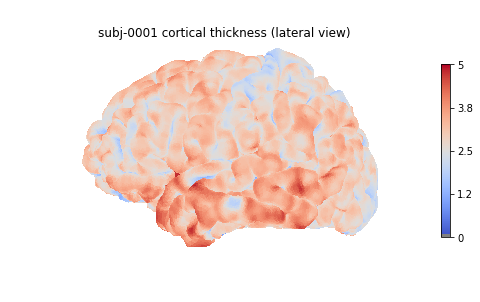

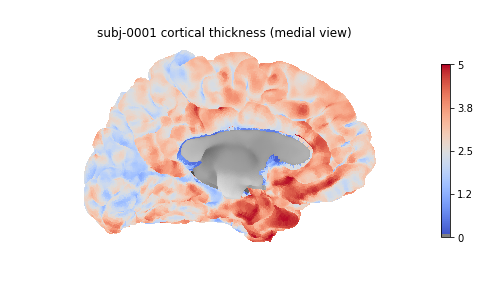

In [77]:
plotting.plot_surf(lh_pial, surf_map=lh_thickness, hemi='left', view='lateral', colorbar=True,
                    bg_map=lh_sulcus, cmap='coolwarm', vmin=0, threshold = 0.1,
                    title='subj-0001 cortical thickness (lateral view)');
plotting.plot_surf(lh_pial, surf_map=lh_thickness, hemi='left', view='medial', colorbar=True,
                    bg_map=lh_sulcus, cmap='coolwarm', vmin=0, threshold = 0.1,
                    title='subj-0001 cortical thickness (medial view)');

#### How to generate FS stats from FS files ?

We can convert from Freesurfer output files format to table format with Freesurfer as done in [this bash script](https://github.com/NILAB-UvA/AOMIC-common-scripts/blob/master/fs_stats/create_freesurfer_tables.sh):

```bash
SUBJECTS=(...)
MEASURE=thickness
PARC=aparc.a2009s
for HEMI in lh rh; do
    echo "Running aparcstats2table with measure ${MEASURE} and parcellation ${parc} for hemisphere ${HEMI}"
    aparcstats2table --subjects ${SUBJECTS[@]} \
      --hemi ${hemi} \
      --parc ${parc} \
      --measure ${MEASURE} \
      --tablefile ../derivatives/fs_stats/data-cortical_type-${parc}_measure-${MEASURE}_hemi-${HEMI}.tsv \
      --delimiter 'tab'           
done
```

Then we can collect the clean aggregated data for all our subjects.

In [480]:
fs_stats_dir = "../local_data/AOMIC/derivatives/fs_stats"
hemi="lh"

We use pandas to read the data into a dataframe.

In [481]:
fs_hemi_df = pd.read_csv(stats_file,sep='\t')
fs_hemi_df

,lh.aparc.a2009s.thickness,lh_G&S_frontomargin_thickness,lh_G&S_occipital_inf_thickness,lh_G&S_paracentral_thickness,lh_G&S_subcentral_thickness,lh_G&S_transv_frontopol_thickness,lh_G&S_cingul-Ant_thickness,lh_G&S_cingul-Mid-Ant_thickness,lh_G&S_cingul-Mid-Post_thickness,lh_G_cingul-Post-dorsal_thickness,...,lh_S_precentral-inf-part_thickness,lh_S_precentral-sup-part_thickness,lh_S_suborbital_thickness,lh_S_subparietal_thickness,lh_S_temporal_inf_thickness,lh_S_temporal_sup_thickness,lh_S_temporal_transverse_thickness,lh_MeanThickness_thickness,BrainSegVolNotVent,eTIV
0,sub-0001,1.925,2.517,2.266,2.636,2.600,2.777,2.606,2.736,2.956,...,2.719,2.302,2.417,2.514,2.485,2.462,2.752,2.56319,1235952.0,1.560839e+06
1,sub-0002,2.405,2.340,2.400,2.849,2.724,2.888,2.658,2.493,3.202,...,2.248,2.342,3.264,2.619,2.212,2.386,2.772,2.45903,1056970.0,1.115228e+06
2,sub-0003,2.477,2.041,2.255,2.648,2.616,2.855,2.924,2.632,2.984,...,2.489,2.276,2.130,2.463,2.519,2.456,2.685,2.53883,945765.0,1.186697e+06
3,sub-0004,2.179,2.137,2.366,2.885,2.736,2.968,2.576,2.593,3.211,...,2.399,2.145,2.920,2.790,2.304,2.564,2.771,2.51093,973916.0,9.527770e+05
4,sub-0005,2.483,2.438,2.219,2.832,2.686,3.397,2.985,2.585,3.028,...,2.569,2.352,3.598,2.331,2.494,2.665,2.538,2.53830,1089881.0,1.497743e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,sub-0222,2.429,2.353,2.240,2.754,2.837,2.886,2.659,2.541,2.848,...,2.468,2.278,2.861,2.383,2.511,2.371,2.453,2.40305,1024683.0,1.187630e+06
222,sub-0223,1.950,2.165,2.331,2.578,2.444,2.765,2.641,2.641,2.953,...,2.249,2.420,2.886,2.361,2.360,2.481,2.192,2.44357,1080928.0,1.210314e+06
223,sub-0224,2.231,2.518,2.137,2.440,2.578,2.809,2.833,2.645,3.084,...,2.487,2.368,2.611,2.636,2.731,2.410,2.377,2.46291,1140289.0,1.302062e+06
224,sub-0225,2.513,2.495,2.141,2.492,2.757,2.553,2.238,2.684,3.065,...,2.479,2.304,2.870,2.275,2.481,2.533,2.009,2.43156,1080245.0,1.395822e+06


Collect data for the Destrieux atlas for left and right hemisphere

In [95]:
fs_df = pd.DataFrame()
for hemi in ['lh','rh']:
    stats_file = os.path.join(fs_stats_dir, 
                              f"data-cortical_type-aparc.a2009s_measure-thickness_hemi-{hemi}.tsv")
    fs_hemi_df = pd.read_csv(stats_file,sep='\t')
    # Rename columns to concat multiple cohorts / hemis and remove verbose freesurfer suffixes
    orig_cols = list(fs_hemi_df.columns)
    roi_and_mean_cols = []
    for col in orig_cols[1:-2]:
        roi_name_with_special_chars = col.split('_',1)[1].rsplit('_',1)[0]
        roi_name = roi_name_with_special_chars.replace('&', '_and_').replace('-', '_')
        roi_and_mean_cols.append(roi_name)                 
    renamed_cols = ['participant_id'] + roi_and_mean_cols
    old2new_roinames = dict(zip(orig_cols, renamed_cols))
    new2old_roinames = dict(zip(renamed_cols, orig_cols))
    fs_hemi_df = fs_hemi_df.rename(columns=old2new_roinames)
    fs_hemi_df['hemi'] = hemi
    fs_df = fs_df.append(fs_hemi_df)
    roi_cols = roi_and_mean_cols[:-1]
    print(f"Hemisphere: {hemi}, Number of ROIs: {len(roi_cols)}")
fs_df.head()

Hemisphere: lh, Number of ROIs: 74
Hemisphere: rh, Number of ROIs: 74


,participant_id,G_and_S_frontomargin,G_and_S_occipital_inf,G_and_S_paracentral,G_and_S_subcentral,G_and_S_transv_frontopol,G_and_S_cingul_Ant,G_and_S_cingul_Mid_Ant,G_and_S_cingul_Mid_Post,G_cingul_Post_dorsal,...,S_precentral_sup_part,S_suborbital,S_subparietal,S_temporal_inf,S_temporal_sup,S_temporal_transverse,MeanThickness,BrainSegVolNotVent,eTIV,hemi
0,sub-0001,1.925,2.517,2.266,2.636,2.600,2.777,2.606,2.736,2.956,...,2.302,2.417,2.514,2.485,2.462,2.752,2.56319,1235952.0,1.560839e+06,lh
1,sub-0002,2.405,2.340,2.400,2.849,2.724,2.888,2.658,2.493,3.202,...,2.342,3.264,2.619,2.212,2.386,2.772,2.45903,1056970.0,1.115228e+06,lh
2,sub-0003,2.477,2.041,2.255,2.648,2.616,2.855,2.924,2.632,2.984,...,2.276,2.130,2.463,2.519,2.456,2.685,2.53883,945765.0,1.186697e+06,lh
3,sub-0004,2.179,2.137,2.366,2.885,2.736,2.968,2.576,2.593,3.211,...,2.145,2.920,2.790,2.304,2.564,2.771,2.51093,973916.0,9.527770e+05,lh
4,sub-0005,2.483,2.438,2.219,2.832,2.686,3.397,2.985,2.585,3.028,...,2.352,3.598,2.331,2.494,2.665,2.538,2.53830,1089881.0,1.497743e+06,lh


#### Plotting distribution of cortical thickness among all subjects

In [482]:
plot_df = fs_df[["hemi"] + roi_cols]
## Melt dataframe for easier visualization
plot_long_df = pd.melt(plot_df, id_vars = ['hemi'], value_vars = roi_cols, 
                       var_name ='ROI', value_name ='cortical thickness')

In [483]:
plot_long_df

,hemi,ROI,cortical thickness
0,lh,G_and_S_frontomargin,1.925
1,lh,G_and_S_frontomargin,2.405
2,lh,G_and_S_frontomargin,2.477
3,lh,G_and_S_frontomargin,2.179
4,lh,G_and_S_frontomargin,2.483
...,...,...,...
33443,rh,S_temporal_transverse,3.006
33444,rh,S_temporal_transverse,2.683
33445,rh,S_temporal_transverse,2.418
33446,rh,S_temporal_transverse,2.105


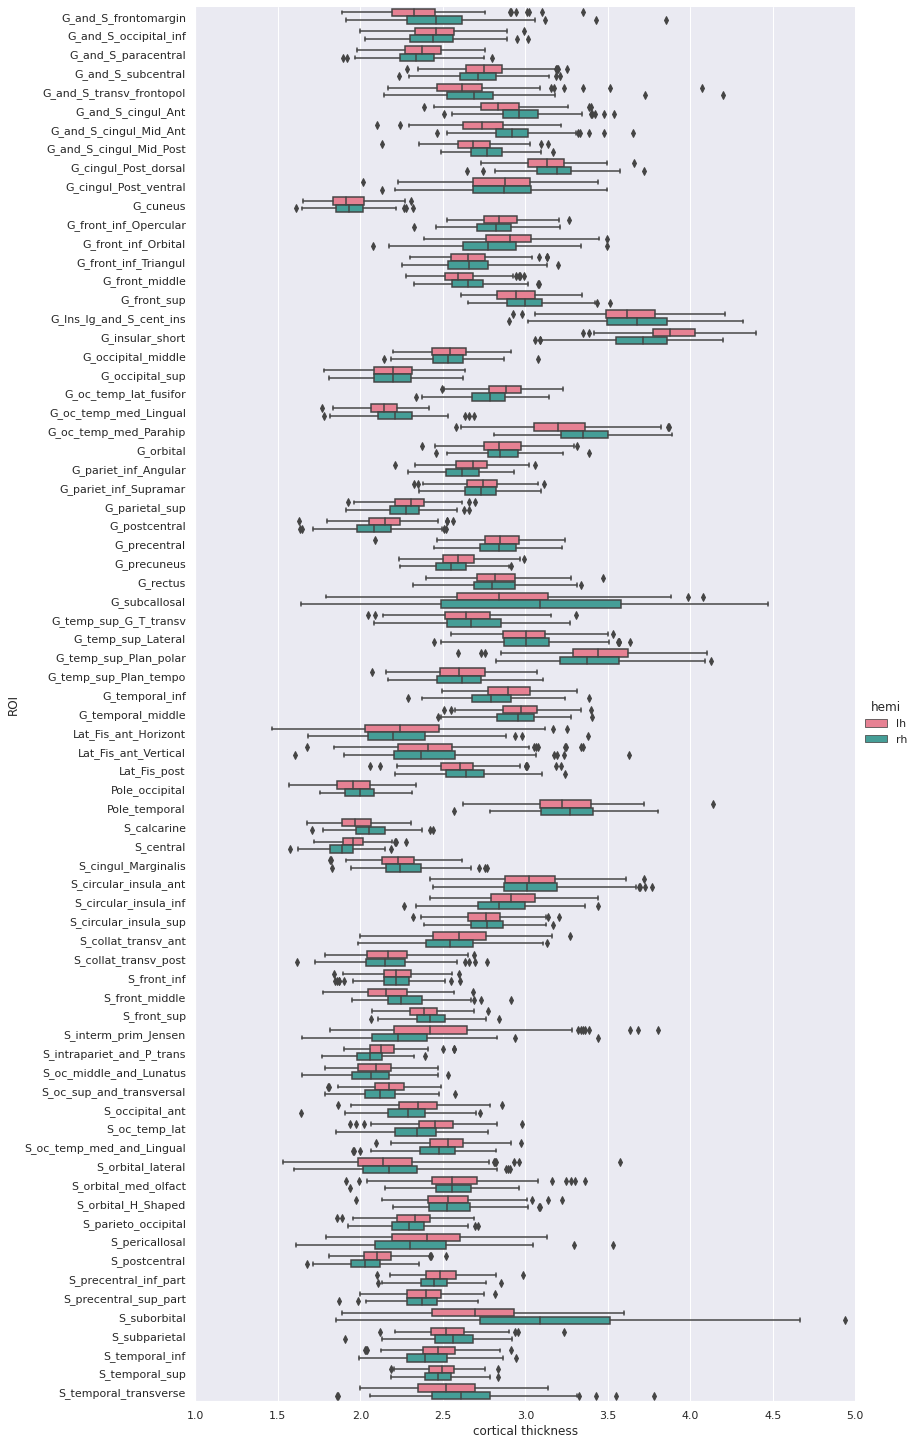

In [484]:
sns.set(font_scale=1)
g = sns.catplot(x='cortical thickness', y='ROI', hue='hemi', kind='box', aspect=0.6, 
                height=20, palette = sns.color_palette('husl',2), data=plot_long_df)
g.set(xlim=(1, 5));

## Statistical analysis: can we measure cortical thickness changes with age in young adults ?

### Creating our model predictors

#### Adding demographic data

In [18]:
subjects_info_withna = bids_layout.get(suffix="participants", extension=".tsv")[0].get_df()

In [19]:
subjects_info_withna

,participant_id,age,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,sub-0001,25.50,M,21.0,right,academic,33.0,23,40,52,47,32
1,sub-0002,23.25,F,22.0,right,academic,19.0,22,47,34,53,46
2,sub-0003,25.00,F,23.0,right,applied,29.0,26,42,37,48,48
3,sub-0004,20.00,F,18.0,right,academic,24.0,32,42,36,48,52
4,sub-0005,24.75,M,27.0,right,academic,24.0,32,51,41,51,53
...,...,...,...,...,...,...,...,...,...,...,...,...
221,sub-0222,22.00,F,20.0,right,academic,30.0,41,35,51,48,42
222,sub-0223,20.75,F,23.0,left,applied,26.0,33,41,54,36,41
223,sub-0224,21.75,M,20.0,right,academic,34.0,22,45,47,46,46
224,sub-0225,20.25,F,28.0,right,academic,27.0,48,32,43,42,37


#### Data cleaning

##### Challenge: there may be an issue with the data. Can you spot it ?

##### Challenge: if you spotted the issue in the previous challenge, what would you propose to solve it ?

In [96]:
demo_cols = ["participant_id", "age", "sex"]
fs_all_df = pd.merge(subjects_info[demo_cols], fs_df, on='participant_id')
fs_all_df

,participant_id,age,sex,G_and_S_frontomargin,G_and_S_occipital_inf,G_and_S_paracentral,G_and_S_subcentral,G_and_S_transv_frontopol,G_and_S_cingul_Ant,G_and_S_cingul_Mid_Ant,...,S_precentral_sup_part,S_suborbital,S_subparietal,S_temporal_inf,S_temporal_sup,S_temporal_transverse,MeanThickness,BrainSegVolNotVent,eTIV,hemi
0,sub-0001,25.50,M,1.925,2.517,2.266,2.636,2.600,2.777,2.606,...,2.302,2.417,2.514,2.485,2.462,2.752,2.56319,1235952.0,1.560839e+06,lh
1,sub-0001,25.50,M,2.216,2.408,2.381,2.698,2.530,2.947,2.896,...,2.324,2.273,2.588,2.548,2.465,2.675,2.51412,1235952.0,1.560839e+06,rh
2,sub-0002,23.25,F,2.405,2.340,2.400,2.849,2.724,2.888,2.658,...,2.342,3.264,2.619,2.212,2.386,2.772,2.45903,1056970.0,1.115228e+06,lh
3,sub-0002,23.25,F,2.682,2.454,2.511,2.725,2.874,3.202,3.012,...,2.429,2.664,2.676,2.220,2.291,2.714,2.48075,1056970.0,1.115228e+06,rh
4,sub-0003,25.00,F,2.477,2.041,2.255,2.648,2.616,2.855,2.924,...,2.276,2.130,2.463,2.519,2.456,2.685,2.53883,945765.0,1.186697e+06,lh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,sub-0224,21.75,M,2.076,2.653,2.098,2.307,2.463,2.735,2.602,...,2.136,3.253,2.495,2.309,2.562,2.418,2.41761,1140289.0,1.302062e+06,rh
448,sub-0225,20.25,F,2.513,2.495,2.141,2.492,2.757,2.553,2.238,...,2.304,2.870,2.275,2.481,2.533,2.009,2.43156,1080245.0,1.395822e+06,lh
449,sub-0225,20.25,F,3.061,2.164,2.097,2.462,2.753,3.134,2.786,...,2.174,3.429,2.385,2.378,2.303,2.105,2.41200,1080245.0,1.395822e+06,rh
450,sub-0226,20.00,M,3.010,2.189,2.562,3.142,4.072,3.051,2.292,...,2.375,2.812,2.756,2.524,2.617,2.495,2.62877,1257771.0,1.583713e+06,lh


#### Looking at a single ROI: e.g. cingulate mid ant

In [130]:
response = 'G_and_S_cingul_Mid_Ant' #'eTIV' 
predictor = 'age'

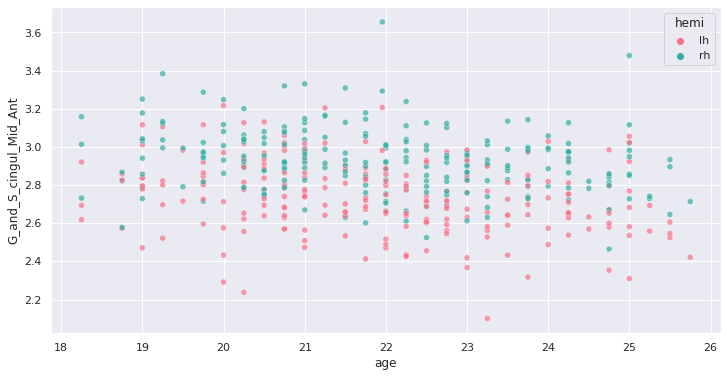

In [131]:
plt.figure(figsize=(12, 6))
g = sns.scatterplot(x=predictor, y=response, hue='hemi', alpha=0.7,
                    palette=sns.color_palette('husl',2), data=plot_df)

### Fitting a regression model

#### Testing the model on a single ROI

In [132]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [134]:
response = 'G_and_S_cingul_Mid_Ant' #'eTIV' 
predictor = 'age'
hemi = 'lh'
hemi_df = fs_all_df[fs_all_df['hemi']==hemi]
covariates = 'eTIV + C(sex)' # [age, sex, BMI, education_category]
# Fit regression model
results = smf.ols(f"{response} ~ {predictor} + {covariates}", data=hemi_df).fit()
# Inspect the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     G_and_S_cingul_Mid_Ant   R-squared:                       0.060
Model:                                OLS   Adj. R-squared:                  0.047
Method:                     Least Squares   F-statistic:                     4.728
Date:                    Thu, 03 Jun 2021   Prob (F-statistic):            0.00322
Time:                            02:41:24   Log-Likelihood:                 62.682
No. Observations:                     226   AIC:                            -117.4
Df Residuals:                         222   BIC:                            -103.7
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.2906      0.183     17.954      0.000       2.929       3.652
C(sex)[T.M]    -0.0097      0.033     -0.296      0.768      -0.074       0.055
age            -0.0258      0.007     -3.706      0.000      -0.040      -0.012
eTIV         1.612e-08   7.58e-08      0.213      0.832   -1.33e-07    1.66e-07
==============================================================================
Omnibus:                        2.038   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.683
Skew:                          -0.157   Prob(JB):                        0.431
Kurtosis:                       3.282   Cond. No.                     2.03e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Implementing it on all ROIs

In [135]:
def format_ols_results(res):
    """ Converts statsmodels summary results (table2) 
    into dataframe with minimum useful stat results"""
    results_summary = res.summary()
    results_as_html = results_summary.tables[1].as_html()
    res_df = pd.read_html(results_as_html, header=0, index_col=0)[0].reset_index()
    res_df['R2'] = res.rsquared
    res_df['R2_adj'] = res.rsquared_adj
    return res_df

In [136]:
# OLS result df
ols_df = pd.DataFrame()
predictor = 'age'
covariates = 'eTIV + C(sex)'
for hemi in ['lh','rh']:
    hemi_df = fs_all_df[fs_all_df['hemi']==hemi]
    for response in roi_cols:
        res = smf.ols(f"{response} ~ {predictor} + {covariates}", data=hemi_df).fit()
        res_df = format_ols_results(res)
        res_df['response'] = response
        res_df['hemi'] = hemi
        ols_df = ols_df.append(res_df)

In [495]:
ols_df

,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,response,hemi
0,Intercept,2.481300e+00,2.210000e-01,11.239,0.000,2.046000e+00,2.916000e+00,0.004184,-0.009273,G_and_S_frontomargin,lh
1,C(sex)[T.M],-7.200000e-03,3.900000e-02,-0.182,0.856,-8.500000e-02,7.100000e-02,0.004184,-0.009273,G_and_S_frontomargin,lh
2,age,-7.700000e-03,8.000000e-03,-0.921,0.358,-2.400000e-02,9.000000e-03,0.004184,-0.009273,G_and_S_frontomargin,lh
3,eTIV,1.781000e-08,9.140000e-08,0.195,0.846,-1.620000e-07,1.980000e-07,0.004184,-0.009273,G_and_S_frontomargin,lh
0,Intercept,2.593400e+00,1.650000e-01,15.732,0.000,2.269000e+00,2.918000e+00,0.018302,0.005035,G_and_S_occipital_inf,lh
...,...,...,...,...,...,...,...,...,...,...,...
3,eTIV,4.495000e-08,4.820000e-08,0.933,0.352,-5.000000e-08,1.400000e-07,0.075192,0.062694,S_temporal_sup,rh
0,Intercept,3.044100e+00,2.870000e-01,10.589,0.000,2.478000e+00,3.611000e+00,0.040983,0.028024,S_temporal_transverse,rh
1,C(sex)[T.M],-8.830000e-02,5.100000e-02,-1.718,0.087,-1.900000e-01,1.300000e-02,0.040983,0.028024,S_temporal_transverse,rh
2,age,-2.590000e-02,1.100000e-02,-2.370,0.019,-4.700000e-02,-4.000000e-03,0.040983,0.028024,S_temporal_transverse,rh


#### Plotting the results with multiple comparison correction

In [496]:
predictors = ['age']
all_rois_df = ols_df[ols_df['index'].isin(predictors)]
# Multiple comparison correction
n_comparisons = 2 * len(roi_cols) # 2 hemispheres
alpha = 0.05
alpha_corr = 0.05 / n_comparisons
# Get significant ROIs and hemis
sign_rois = all_rois_df[all_rois_df['P>|t|'] < alpha_corr]['response'].values
sign_hemis = all_rois_df[all_rois_df['P>|t|'] < alpha_corr]['hemi'].values
# Printing correction properties and results
print(f"Bonferroni correction with {n_comparisons} multiple comparisons")
print(f'Using corrected alpha threshold of {alpha_corr:5.4f}')
print("Significant ROIs:")
print(list(zip(sign_rois, sign_hemis)))

Bonferroni correction with 148 multiple comparisons
Using corrected alpha threshold of 0.0003
Significant ROIs:
[('G_and_S_cingul_Mid_Ant', 'lh'), ('G_and_S_cingul_Mid_Post', 'lh'), ('G_front_inf_Opercular', 'lh'), ('G_front_middle', 'lh'), ('G_front_sup', 'lh'), ('G_occipital_middle', 'lh'), ('G_temp_sup_G_T_transv', 'lh'), ('S_circular_insula_sup', 'lh'), ('S_front_middle', 'lh'), ('S_front_sup', 'lh'), ('S_parieto_occipital', 'lh'), ('S_precentral_sup_part', 'lh'), ('S_temporal_sup', 'lh'), ('G_and_S_cingul_Mid_Post', 'rh'), ('G_cuneus', 'rh'), ('G_front_inf_Triangul', 'rh'), ('G_front_middle', 'rh'), ('G_front_sup', 'rh'), ('G_pariet_inf_Angular', 'rh'), ('G_precentral', 'rh'), ('G_rectus', 'rh'), ('G_temporal_middle', 'rh'), ('S_circular_insula_sup', 'rh'), ('S_front_sup', 'rh')]


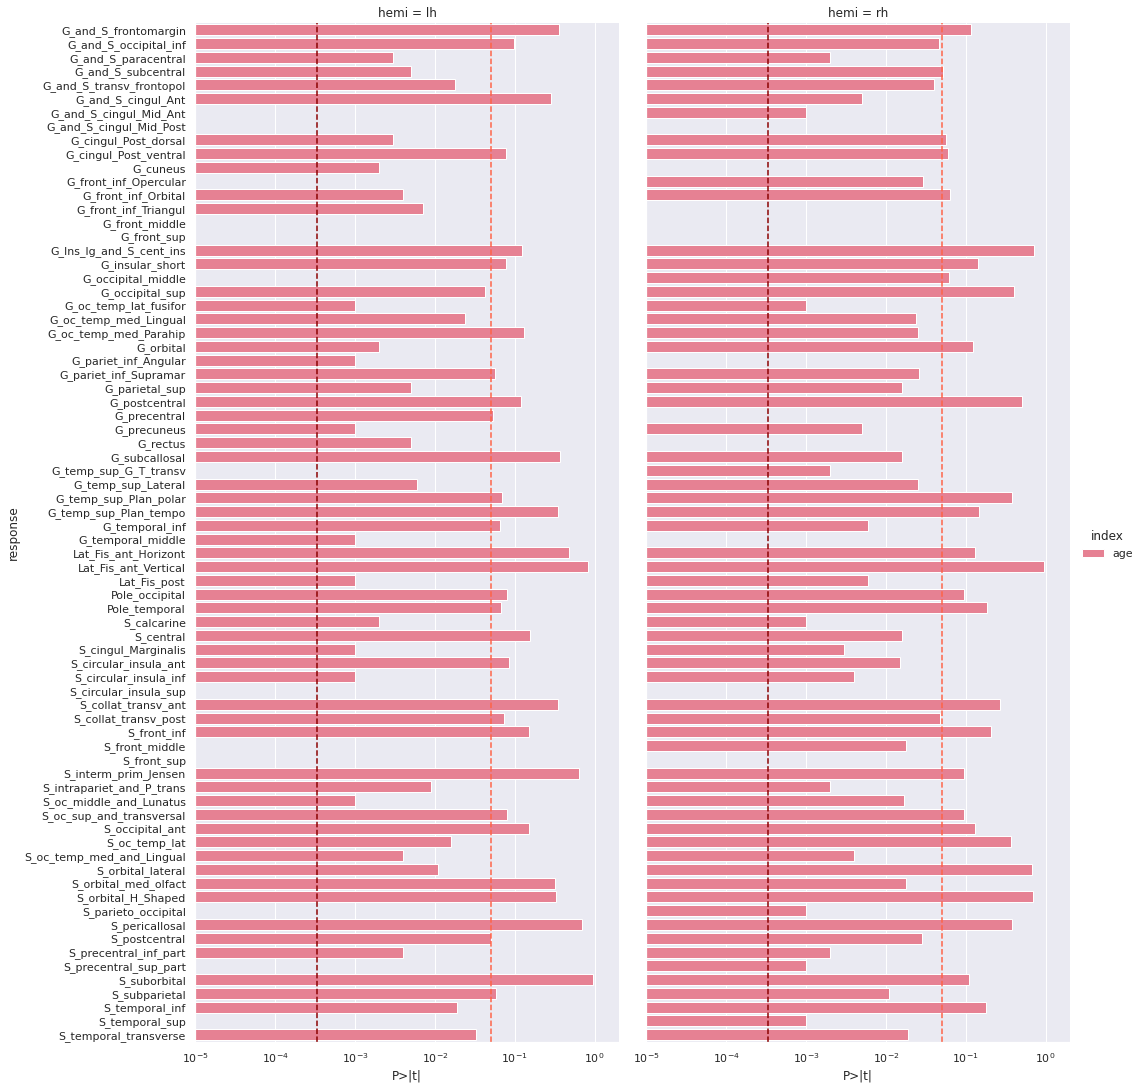

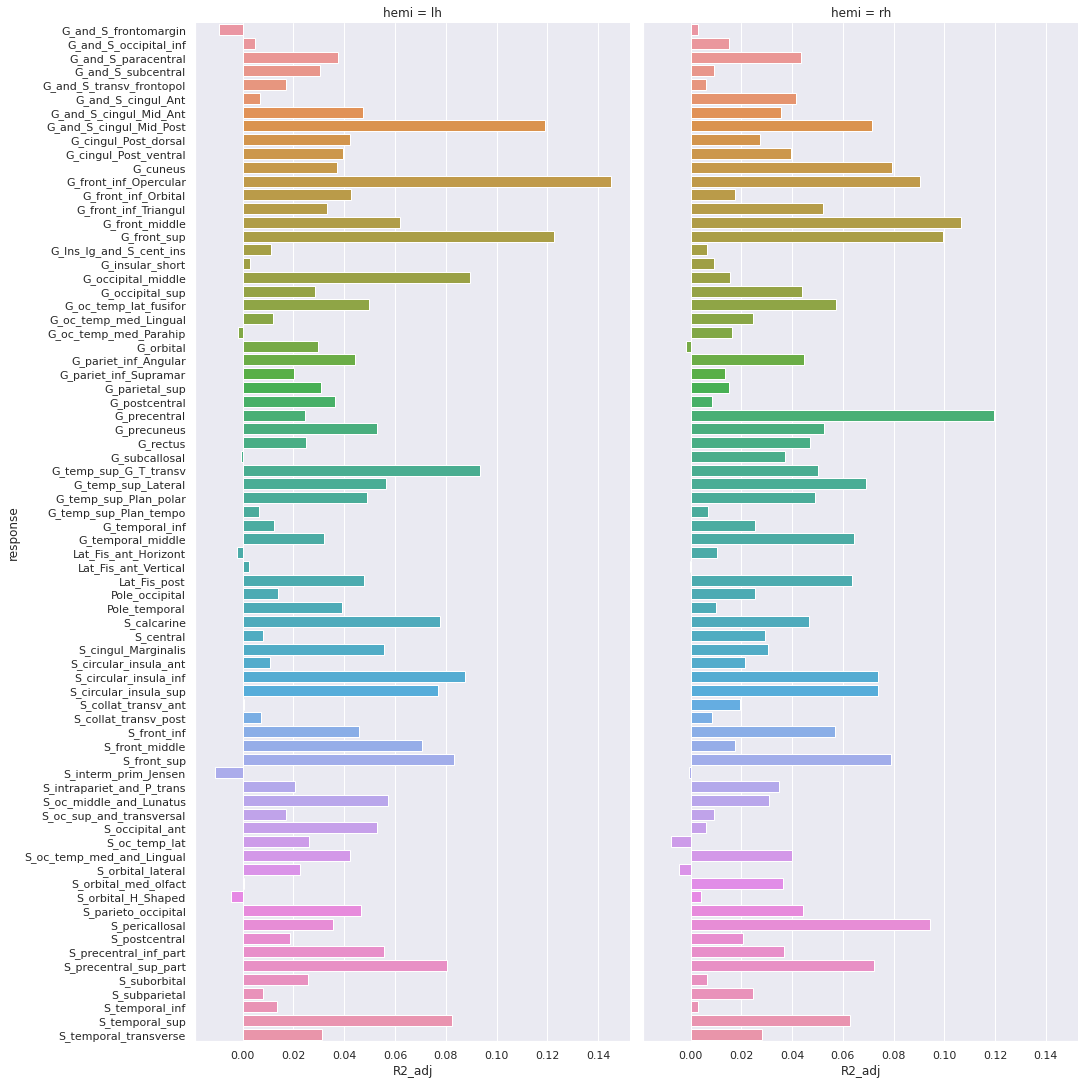

In [150]:
sns.set(font_scale=1)
g = sns.catplot(x='P>|t|', y='response', kind='bar', hue='index', col='hemi',
                aspect=0.5, height=15, palette=sns.color_palette('husl',2), data=all_rois_df)
g.set(xscale='log',xlim=(1e-5,2))
for ax in g.axes.flat:
    ax.axvline(alpha, ls='--',c='tomato')
    ax.axvline(alpha_corr, ls='--',c='darkred')

g = sns.catplot(x='R2_adj', y='response', col='hemi', kind='bar', 
                aspect=0.5, height=15, data=all_rois_df)

#### Visualizing the results on a mesh

In [154]:
from nilearn import datasets

In [151]:
## Nilearn label strings for the Destrieux atlas are slightly different than what FreeSurfer uses. 
## Use this function to convert between them.
def map_fs_names_to_nilearn(stat_df, new2old_roinames):
    sign_rois = stat_df[stat_df['P>|t|'] < alpha_corr]['response'].values
    sign_hemis = stat_df[stat_df['P>|t|'] < alpha_corr]['hemi'].values

    nilearn_stats_lh = {}
    nilearn_stats_rh = {}
    for roi, hemi in zip(sign_rois, sign_hemis):
        nilearn_label = new2old_roinames[roi]
        nilearn_label = nilearn_label.replace('&', '_and_')
        #remove hemisphere prefix and thickness suffix from the name
        nilearn_label = nilearn_label.split('_',1)[1].rsplit('_',1)[0]
        t_stat = stat_df[(stat_df['response'] == roi) & (stat_df['hemi'] == hemi)]['t'].values[0]
        if hemi == 'lh':
            nilearn_stats_lh[nilearn_label] = t_stat
        elif hemi == 'rh':
            nilearn_stats_rh[nilearn_label] = t_stat
        else:
            print('unknown hemisphere')
    return nilearn_stats_lh, nilearn_stats_rh

In [155]:
# Retrieve both the Destrieux atlas and labels
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
parcellation = destrieux_atlas['map_left']
labels = destrieux_atlas['labels']
labels = [l.decode('utf-8') for l in labels]
# Retrieve fsaverage5 surface dataset for the plotting background.
fsaverage = datasets.fetch_surf_fsaverage()

In [156]:
### Assign a t-score to each surface atlas ROI
stat_map_lh = np.zeros(parcellation.shape[0], dtype=int)
nilearn_stats_lh, nilearn_stats_rh = map_fs_names_to_nilearn(all_rois_df, new2old_roinames)
# For left hemisphere
for roi, t_stat in nilearn_stats_lh.items():
    stat_labels = np.where(parcellation == labels.index(roi))[0]
    stat_map_lh[stat_labels] = t_stat
# For right hemisphere
stat_map_rh = np.zeros(parcellation.shape[0], dtype=int)
for roi, t_stat in nilearn_stats_rh.items():
    stat_labels = np.where(parcellation == labels.index(roi))[0]
    stat_map_rh[stat_labels] = t_stat

In [424]:
plotting.plot_surf_roi?

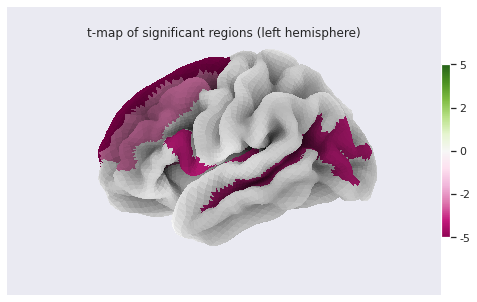

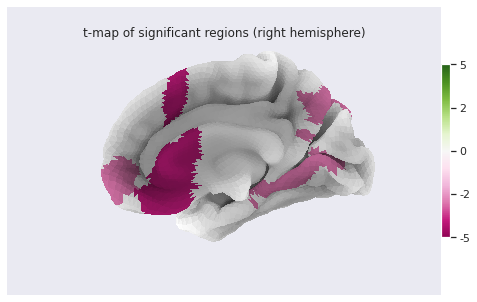

In [501]:
# LATERAL view of the LEFT hemisphere
plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=stat_map_lh,
                       hemi='left', view='lateral', cmap='PiYG', colorbar = True,
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       title='t-map of significant regions (left hemisphere)',
                       vmin=-5, vmax=5);
# MEDIAL view of the RIGHT hemisphere
plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=stat_map_rh,
                       hemi='right', view='medial', cmap='PiYG',  colorbar = True,
                       bg_map=fsaverage['sulc_right'], bg_on_data=True,
                       title='t-map of significant regions (right hemisphere)',
                       vmin=-5, vmax=5);

## VBM

In [191]:
vbm_subset_dir = os.path.join(vbm_dir, "subset")
vbm_cohort_dir = os.path.join(vbm_dir, "all_subjects")

### Processing: template

In [160]:
from nilearn.image import concat_imgs, mean_img

#### Template from GM probability maps in MNI space

##### Implementation on a subset of 10 subjects

In [205]:
GM10_probmap_files = glob.glob(os.path.join(fmriprep_dir, "sub-*", "anat", "*MNI*GM_probseg.nii.gz"))

In [206]:
# Template creation on a subset of 10 subject
GM10_probmap_files
GM10_probmaps_4D_img = concat_imgs(GM10_probmap_files)
GM10_probmap_mean_img = mean_img(GM10_probmaps_4D_img)
GM10_probmap_mean_img.to_filename(os.path.join(vbm_dir, "GM10.nii.gz"))

##### Loading data for the whole cohort

In [207]:
GM226_probmap_mean_img = nib.load(os.path.join(vbm_cohort_dir, "GM226.nii.gz"))

#### Resample to 2-mm template

In [171]:
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img

##### Implementation on a subset of 10 subjects

In [208]:
template = load_mni152_template()
GM10_probmap_mean_img_2mm = resample_to_img(GM10_probmap_mean_img, template)
GM10_probmap_mean_img_2mm.to_filename(os.path.join(vbm_dir, "GM10_2mm.nii.gz"))

##### Loading data for the whole cohort

In [210]:
GM226_probmap_mean_img_2mm = nib.load(os.path.join(vbm_cohort_dir, "GM226_2mm.nii.gz"))

##### Plot results

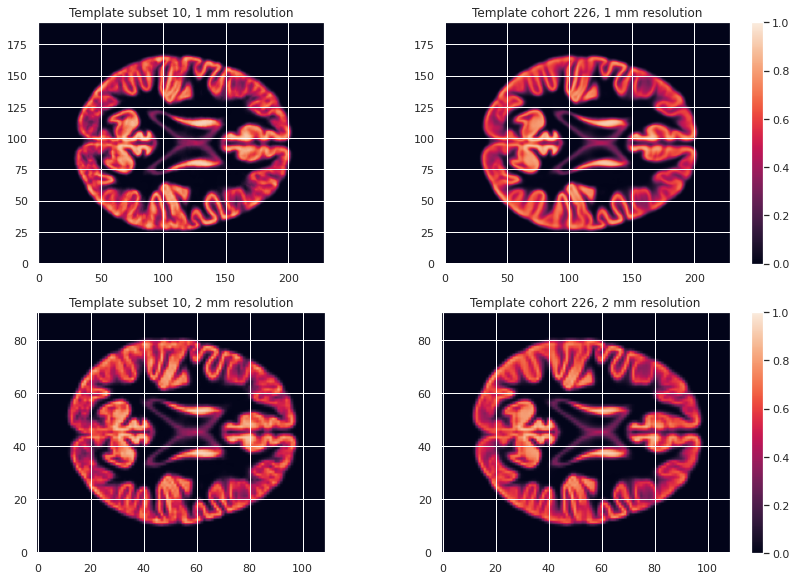

In [215]:
plt.figure(figsize=(12, 16))
n_plots = 4
n_cols = 2
### Plot 1 mm templates
# Subset 10
plt.subplot(n_plots, n_cols, 1)
plt.imshow(GM10_probmap_mean_img.get_fdata()[:, :, 100], origin="lower", vmin=0, vmax=1)
plt.title('Template subset 10, 1 mm resolution')
# Cohort 256
plt.subplot(n_plots, n_cols, 2)
plt.imshow(GM226_probmap_mean_img.get_fdata()[:, :, 100], origin="lower", vmin=0, vmax=1)
plt.title('Template cohort 226, 1 mm resolution')
plt.colorbar();
### Plot 2 mm templates
# Subset 10
# Plot first figure
plt.subplot(n_plots, n_cols, 3)
plt.imshow(GM10_probmap_mean_img_2mm.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
plt.title('Template subset 10, 2 mm resolution')
# Cohort 256
# Plot first figure
plt.subplot(n_plots, n_cols, 4)
plt.imshow(GM226_probmap_mean_img_2mm.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
plt.title('Template cohort 226, 2 mm resolution')
plt.colorbar();
plt.tight_layout() # Magic command to clean the overall plot

### Processing: Jacobian (do not run in this notebook)

In [278]:
GM_native_probmap_files = sorted(glob.glob(os.path.join(fmriprep_dir, "sub-000[0-5]", "anat",
                                                        "sub-000[0-5]_label-GM_probseg.nii.gz")))

```bash
#NATIVE_GM_MAPS=(data/derivatives_mni/smriprep/sub-*/anat/sub-+([0-9])_label-GM_probseg.nii.gz)
NATIVE_GM_MAPS=(data/derivatives/fmriprep/sub-*/anat/sub-+([0-9])_label-GM_probseg.nii.gz)
for GM_MAP in ${NATIVE_GM_MAPS[@]}; do 
    SUBJ_NAME=${GM_MAP%%_label*}
    fsl_reg ${GM_MAP} GM226_2mm.nii.gz \
            data/derivatives/vbm/subset/${SUBJ_NAME}/${SUBJ_NAME}_space-GM226_label-GM_probseg \
            -fnirt "--config=GM_2_MNI152GM_2mm.cnf \
            --jout=data/derivatives/vbm/subset/${SUBJ_NAME}/${SUBJ_NAME}_J"
done
```

### Processing: compute GM modulated maps

In [178]:
from nilearn.image import math_img, smooth_img

#### Compute Jacobians, create 4D merge and then mean images of warped GM, Jacobian and modulated GM

##### Implementation on a subset of 10 subjects

In [217]:
subj_dirs = sorted(glob.glob(os.path.join(vbm_subset_dir, "sub-*")))
# Calculating 
for subj_dir in subj_dirs:
    subj_name = os.path.basename(subj_dir)
    print(f"==={subj_name}")
    # Get GM probability map in template space
    warped_GM_file = os.path.join(subj_dir, f"{subj_name}_space-GM226_label-GM_probseg.nii.gz")
    warped_GM = nib.load(warped_GM_file)
    # Get scaling factors (trace of Jacobian)
    J_map_file = os.path.join(subj_dir, f"{subj_name}_J.nii.gz")
    J_map = nib.load(J_map_file)
    # Compute modulated map
    modulated_map = math_img("img1 * img2", img1=warped_GM, img2=J_map)
    # Save modulated image
    modulated_map_file = os.path.join(subj_dir, f"{subj_name}_space-GM226_label-GM_mod.nii.gz")
    modulated_map.to_filename(modulated_map_file)

===sub-0001
===sub-0002
===sub-0003
===sub-0004
===sub-0005
===sub-0006
===sub-0007
===sub-0008
===sub-0009
===sub-0010


In [242]:
### 4D merge and mean

## Warped GM maps
warped_10map_files = sorted(glob.glob(os.path.join(vbm_subset_dir, "sub*", "*GM_probseg.nii.gz")))
warped_10maps_4D = concat_imgs(warped_10map_files) # 4D merge
warped_10maps_mean = mean_img(warped_10maps_4D) # Mean
# Save mean
warped_10maps_mean_file = os.path.join(vbm_dir, "subset_space-GM226_label-GM_probseg_mean.nii.gz")
warped_10maps_mean.to_filename(warped_10maps_mean_file)

## Jacobian maps
J_10map_files = sorted(glob.glob(os.path.join(vbm_subset_dir, "sub*", "*J.nii.gz")))
J_10maps_4D = concat_imgs(J_10map_files) # 4D merge
J_10maps_mean = mean_img(J_10maps_4D) # Mean
# Save mean
J_10maps_mean_file = os.path.join(vbm_dir, "subset_space-GM226_label-GM_J_mean.nii.gz")
J_10maps_mean.to_filename(warped_10maps_mean_file)

## Modulated maps
modulated_10map_files = sorted(glob.glob(os.path.join(vbm_subset_dir, "sub*", "*GM_mod.nii.gz")))
modulated_10maps_4D = concat_imgs(modulated_10map_files) # 4D merge
modulated_10maps_mean = mean_img(modulated_10maps_4D) # Mean
# Save 4D maps
modulated_10maps_4D_file = os.path.join(vbm_dir, "subset_space-GM226_label-GM_mod.nii.gz")
modulated_10maps_4D.to_filename(modulated_10maps_4D_file)
# Save mean
modulated_10maps_mean_file = os.path.join(vbm_dir, "subset_space-GM226_label-GM_mod_mean.nii.gz")
modulated_10maps_mean.to_filename(modulated_10maps_mean_file)

##### Loading data for the whole cohort

In [244]:
# Warped GM maps
warped_226maps_mean_file = os.path.join(vbm_cohort_dir, "cohort_space-GM226_label-GM_probseg_mean.nii.gz")
warped_226maps_mean = nib.load(warped_226maps_mean_file)
# Jacobian maps
J_226maps_mean_file = os.path.join(vbm_cohort_dir, "cohort_space-GM226_label-GM_J_mean.nii.gz")
J_226maps_mean = nib.load(J_226maps_mean_file)
# Modulated maps
modulated_226maps_mean_file = os.path.join(vbm_cohort_dir, "cohort_space-GM226_label-GM_mod_mean.nii.gz")
modulated_226maps_mean = nib.load(modulated_226maps_mean_file)

#### Plot results

In [313]:
from matplotlib.colors import LogNorm
from matplotlib import ticker

##### For a couple subjects

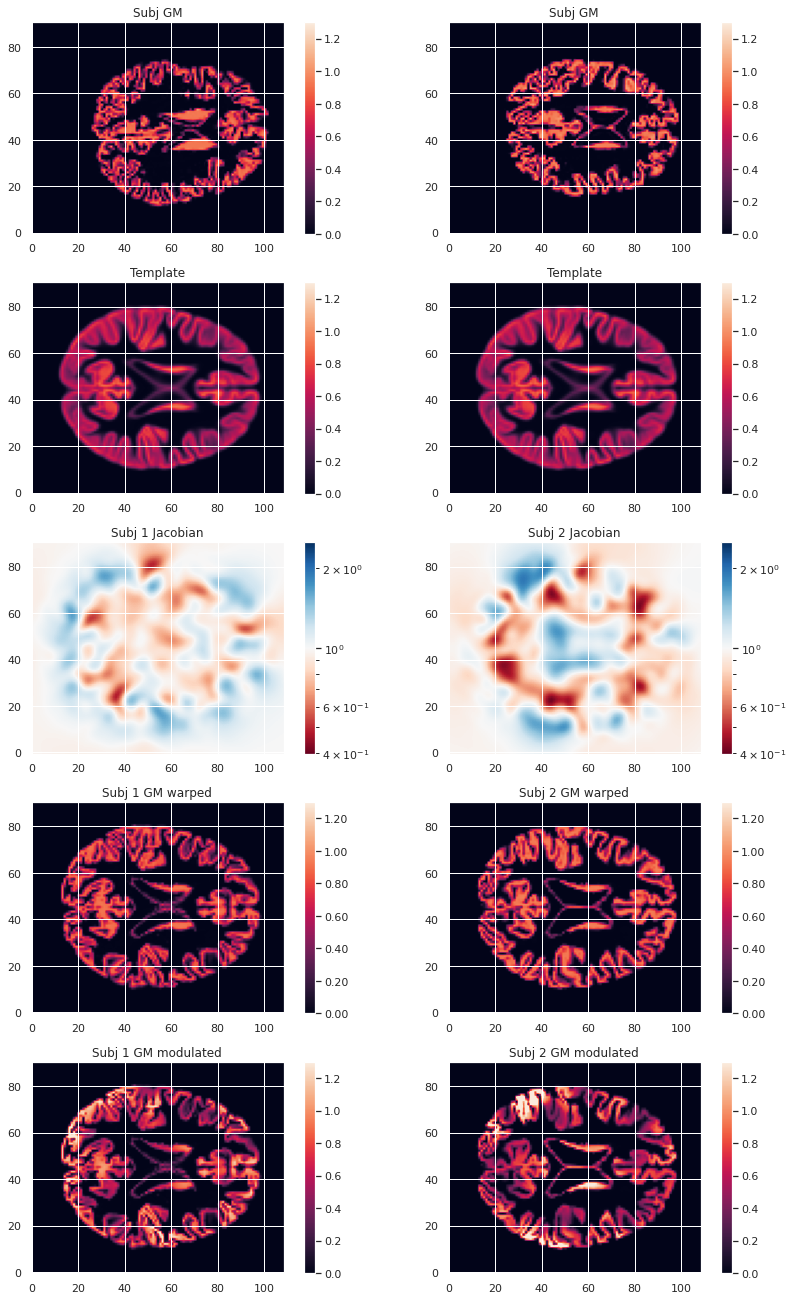

In [351]:
plt.figure(figsize=(12, 36))
subs = [1, 2]
n_sub = len(subs)
n_plots, n_cols = 5*n_sub, n_sub
i_slice_match = {1: 50, 2: 52}
for i_sub, sub in enumerate(subs):
    ### Original image
    plt.subplot(n_plots, n_cols, (i_sub+1))
    GM_native_probmap_file = GM_native_probmap_files[sub]
    GM_native_probmap = nib.load(GM_native_probmap_file)
    GM_native_probmap_2mm = resample_to_img(GM_native_probmap, template)
    i_slice = i_slice_match[sub]
    plt.imshow(GM_native_probmap_2mm.get_fdata()[:, :, i_slice], origin="lower", vmin=0, vmax=1.3)
    plt.title('Subj GM')
    plt.colorbar();
    ### Template
    plt.subplot(n_plots, n_cols, (i_sub+1)+1*n_sub)
    plt.imshow(GM226_probmap_mean_img_2mm.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1.3)
    plt.title('Template')
    plt.colorbar();
    # Jacobian
    plt.subplot(n_plots, n_cols, (i_sub+1)+2*n_sub)
    #plt.imshow(np.log(J_10maps_4D.get_fdata()[:, :, 47, sub]), origin="lower", 
    #           vmin=-1, vmax=1, cmap="RdBu")
    log_ticks = np.logspace(-0.4, 0.4, 10)
    plt.imshow(J_10maps_4D.get_fdata()[:, :, 47, sub], origin="lower", norm=LogNorm(),
               vmin=log_ticks[0], vmax=log_ticks[-1], cmap="RdBu")
    plt.title(f'Subj {i_sub+1} Jacobian')
    plt.colorbar();
    # Warped image
    plt.subplot(n_plots, n_cols, (i_sub+1)+3*n_sub)
    plt.imshow(warped_10maps_4D.get_fdata()[:, :, 47, sub], origin="lower", vmin=0, vmax=1.3)
    plt.title(f'Subj {i_sub+1} GM warped')
    plt.colorbar(format="%0.2f");
    # Subset 10
    plt.subplot(n_plots, n_cols, (i_sub+1)+4*n_sub)
    plt.imshow(modulated_10maps_4D.get_fdata()[:, :, 47, sub], origin="lower", vmin=0, vmax=1.3)
    plt.title(f'Subj {i_sub+1} GM modulated')
    plt.colorbar();
plt.tight_layout() # Magic command to clean the overall plot

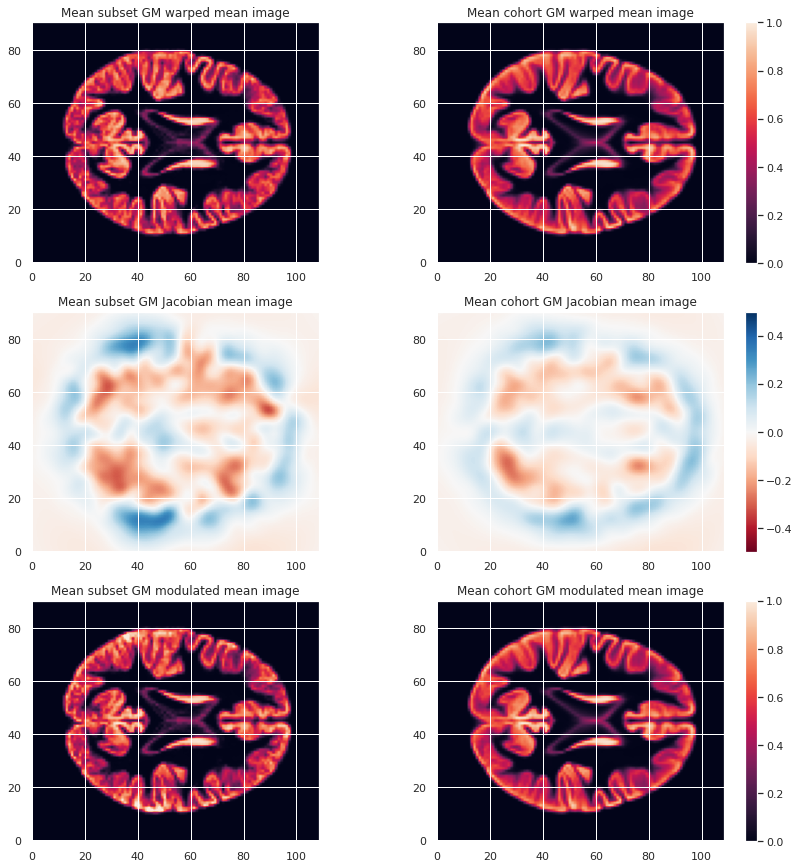

In [249]:
plt.figure(figsize=(12, 24))
n_plots, n_cols = 6, 2
### Plot GM warped maps
# Subset 10
plt.subplot(n_plots, n_cols, 1)
plt.imshow(warped_10maps_mean.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
plt.title('Mean subset GM warped mean image')
# Cohort 256
plt.subplot(n_plots, n_cols, 2)
plt.imshow(warped_226maps_mean.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
plt.title('Mean cohort GM warped mean image')
plt.colorbar();
### Plot Jacobian maps
# Subset 10
plt.subplot(n_plots, n_cols, 3)
plt.imshow(np.log(J_10maps_mean.get_fdata()[:, :, 47]), origin="lower", vmin=-0.5, vmax=0.5, cmap="RdBu")
plt.title('Mean subset GM Jacobian mean image')
# Cohort 256
plt.subplot(n_plots, n_cols, 4)
plt.imshow(np.log(J_226maps_mean.get_fdata()[:, :, 47]), origin="lower", vmin=-0.5, vmax=0.5, cmap="RdBu")
plt.title('Mean cohort GM Jacobian mean image')
plt.colorbar();
### Plot GM modulated maps
# Subset 10
plt.subplot(n_plots, n_cols, 5)
plt.imshow(modulated_10maps_mean.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
plt.title('Mean subset GM modulated mean image')
# Cohort 256
plt.subplot(n_plots, n_cols, 6)
plt.imshow(modulated_226maps_mean.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
plt.title('Mean cohort GM modulated mean image')
plt.colorbar();
plt.tight_layout() # Magic command to clean the overall plot

### Processing: GM mask

In [365]:
GM_mask = math_img('img > 0.05', img=modulated_226maps_mean)
GM_mask.to_filename(os.path.join(vbm_dir, "GM226_mask.nii.gz"))

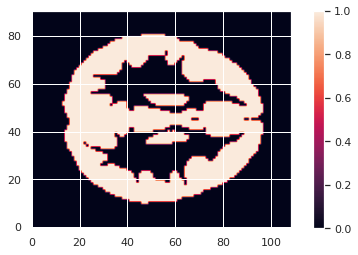

In [366]:
plt.figure(figsize=(8, 4))
plt.imshow(GM_mask.get_fdata()[:, :, 50], origin="lower", vmin=0, vmax=1)
plt.colorbar();

### Statistics: design matrix

#### Design matrix

In [367]:
design_matrix = subjects_info[["participant_id", "age", "sex"]].set_index("participant_id")
design_matrix = pd.get_dummies(design_matrix, columns=["sex"], drop_first=True)
design_matrix["intercept"] = 1
design_matrix

,age,sex_M,intercept
participant_id,,,
sub-0001,25.50,1,1
sub-0002,23.25,0,1
sub-0003,25.00,0,1
sub-0004,20.00,0,1
sub-0005,24.75,1,1
...,...,...,...
sub-0222,22.00,0,1
sub-0223,20.75,0,1
sub-0224,21.75,1,1


In [375]:
dm10 = design_matrix.iloc[:10]
dm10

,age,sex_M,intercept
participant_id,,,
sub-0001,25.50,1,1
sub-0002,23.25,0,1
sub-0003,25.00,0,1
sub-0004,20.00,0,1
sub-0005,24.75,1,1
sub-0006,23.75,1,1
sub-0007,19.25,0,1
sub-0008,21.00,1,1
sub-0009,24.75,0,1


### Statistics: second level GLM

In [428]:
from nilearn.glm.second_level import SecondLevelModel

In [429]:
from nilearn.glm import threshold_stats_img

In [430]:
from nilearn.reporting import make_glm_report

In [431]:
from nilearn.plotting import plot_stat_map

##### Implementation on a subset of 10 subjects

In [432]:
level2_glm10 = SecondLevelModel(smoothing_fwhm=3.0, mask_img=GM_mask)
level2_glm10.fit(modulated_10map_files, design_matrix=dm10)

SecondLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f3543dad610>,
                 smoothing_fwhm=3.0)

In [433]:
zmap10 = level2_glm10.compute_contrast(second_level_contrast=[1, 0, 0], output_type='z_score')

In [434]:
zmap10_thr, zthr = threshold_stats_img(zmap10, mask_img=GM_mask, alpha=.05, 
                                       height_control='fpr', cluster_threshold=50)
zthr

1.9599639845400545

/opt/conda/shared/envs/ni38/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



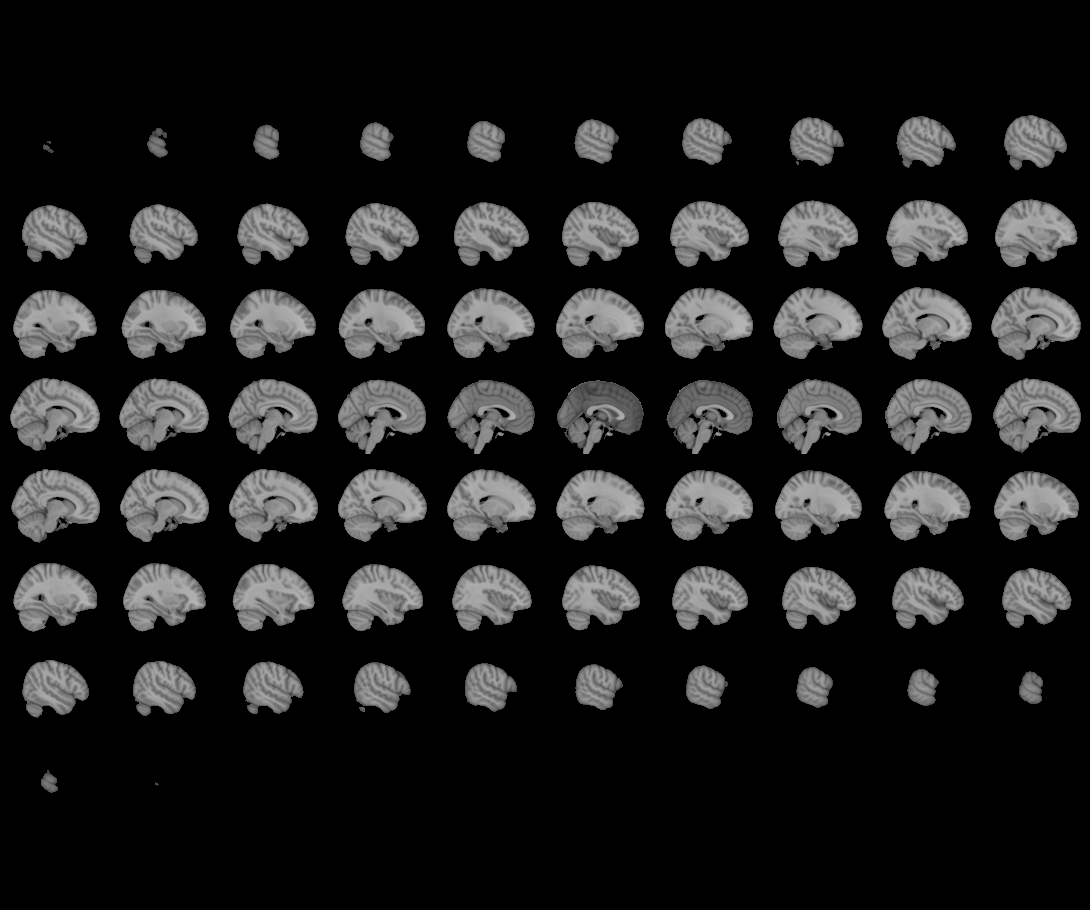
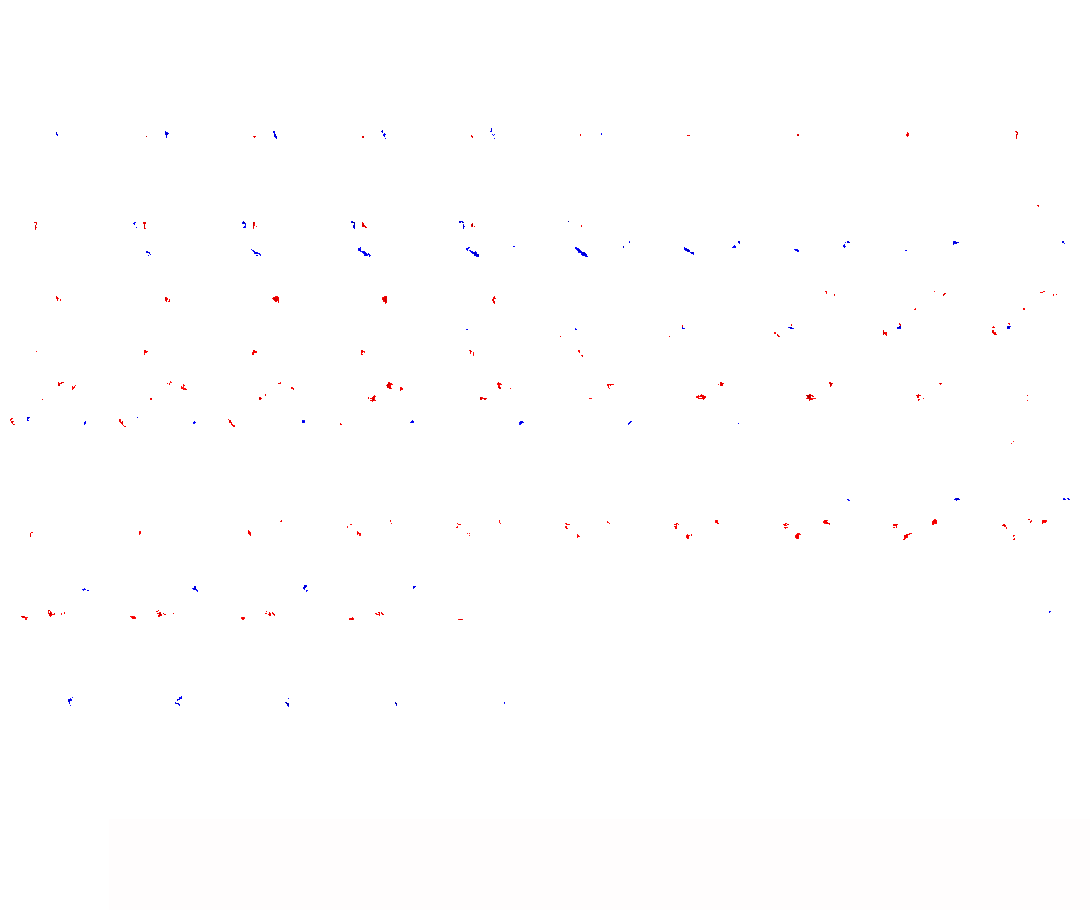

In [498]:
plotting.view_img(zmap10_thr, threshold=threshold, cmap="seismic")

##### Loading data for the whole cohort

In [436]:
zmap226_file = os.path.join(vbm_dir, "zmap_raw_GM226_age.nii.gz")
zmap226 = nib.load(zmap226_file)

In [437]:
zmap226_thr, zthr = threshold_stats_img(zmap226, mask_img=GM_mask, alpha=.05, 
                                        height_control='fpr', cluster_threshold=50)

/opt/conda/shared/envs/ni38/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



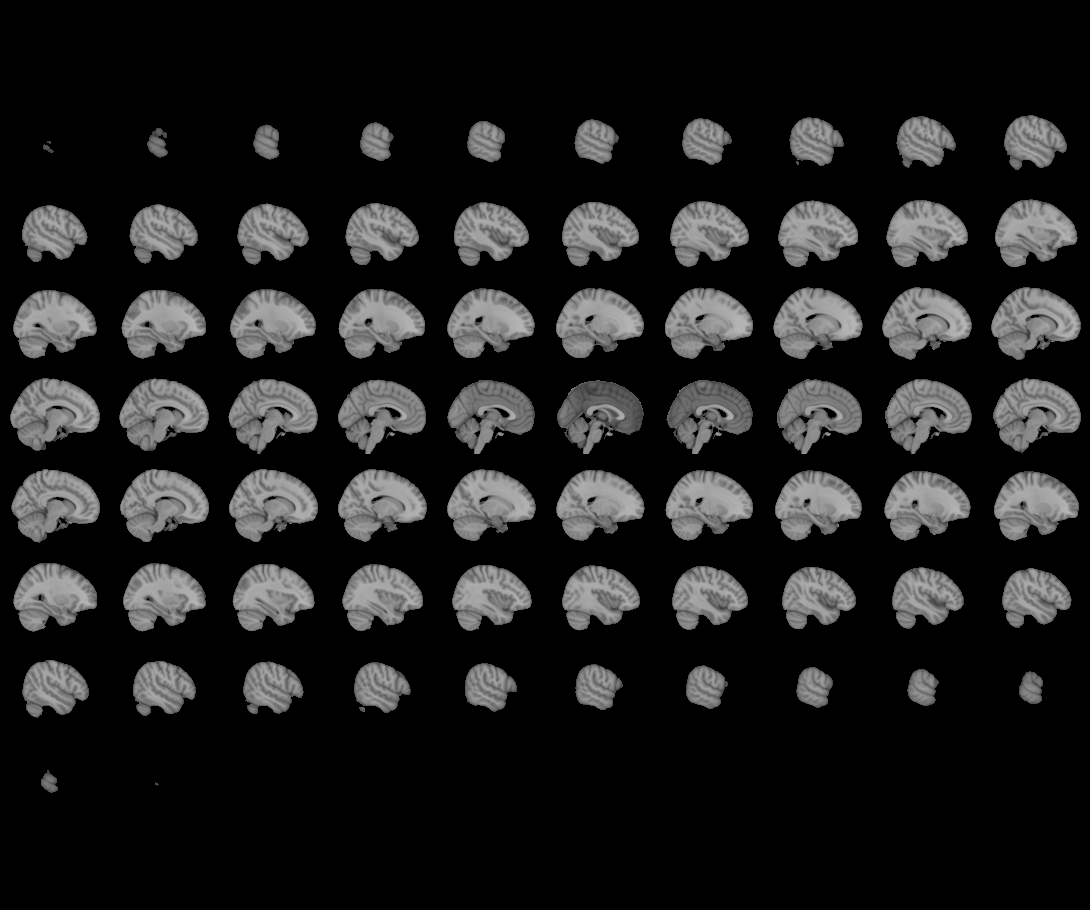
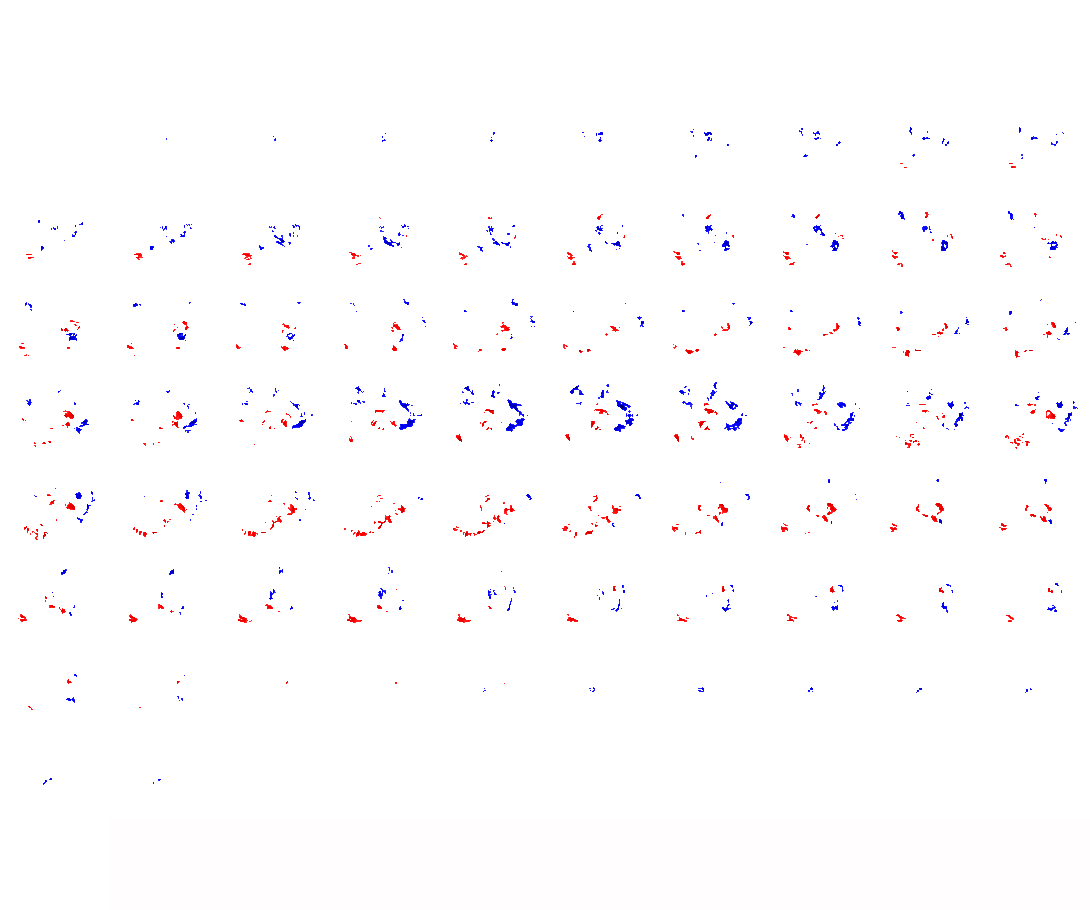

In [499]:
plotting.view_img(zmap226_thr, threshold=zthr, cmap="seismic")

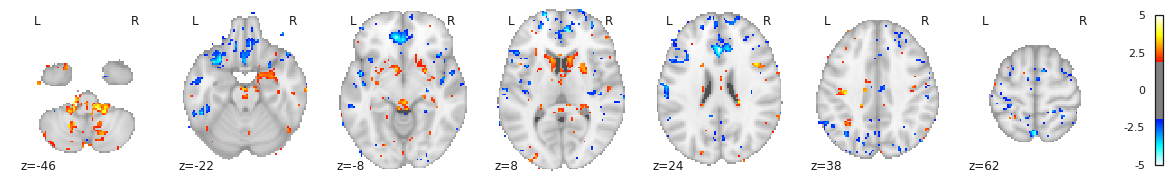

In [414]:
plotting.plot_stat_map(zmap226, threshold=zthr, colorbar=True, display_mode='z');